In [26]:
import lightkurve as lk
import numpy as np
import dynesty
import corner
import scipy 
import pandas as pd
import seaborn as sns

from functools import partial
import jax.numpy as jnp
from jax import jit
from sklearn.decomposition import PCA

## Read in the APOKASC catalogue

https://www.dropbox.com/s/k33td8ukefwy5tv/APOKASC2_Table5.txt?dl=0;

In [27]:
sfile = '../data/APOKASC2_Table5.txt'
df = pd.read_csv(sfile, sep='\t')
df = df.loc[df.Teff > 10]
df = df.loc[df.Dnu > 7]
df = df[['KIC', 'Dnu', 'Nmax', 'Teff']]
df.head()

,KIC,Dnu,Nmax,Teff
11,1294122,7.032,75.309,4803.1
12,1294385,9.116,106.469,4818.8
14,1296507,10.310,126.833,4944.5
16,1431059,13.668,170.839,4825.5
21,1433803,12.160,150.192,4725.7


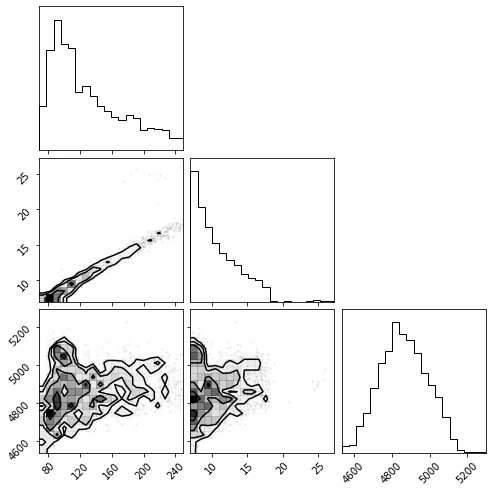

In [28]:
corner.corner(df[['Nmax', 'Dnu', 'Teff']]);

In [77]:
class expand():
    def __init__(self, plot=True):
        self.plot = plot
    
    def learn(self, X, n_components=2):
        '''
        X: array-like
            The training data
        
        '''
        self.pca = PCA(n_components=n_components)
        self.pca.fit(np.log10(X))
        print(f'Explained variance : {self.pca.explained_variance_ratio_}')
        
    def outlier_rejection(self):
        pass
    
    def get_latent_summary(self, D):
        latent = self.transform(D)
        self.summary = [np.mean(latent, axis=0), np.std(latent, axis=0)]
    
    def plot_compare(self, D):
        fig = corner.corner(D, color='r')
        latent = self.transform(D)
        D_ = self(latent)
        corner.corner(D_, fig=fig, color='b')
        
    def plot_latent(self, D):
        latent = self.transform(D)
        fig = corner.corner(latent, color='r')
        self.get_latent_summary(full)
        mc = np.random.multivariate_normal(self.summary[0], 
                                           [[self.summary[1][0]**2, 0],
                                            [0, self.summary[1][1]**2]],
                                          size=100)
        print(mc.shape)
        corner.corner(mc, fig=fig)
    
    def transform(self, D): 
        if np.any(D < 0):
            print('Negative numbers?!?')
        return self.pca.transform(np.log10(D))
    
    def __call__(self, latent):
        return 10**self.pca.inverse_transform(latent)

Explained variance : [0.84890031 0.08957637]


(100, 2)


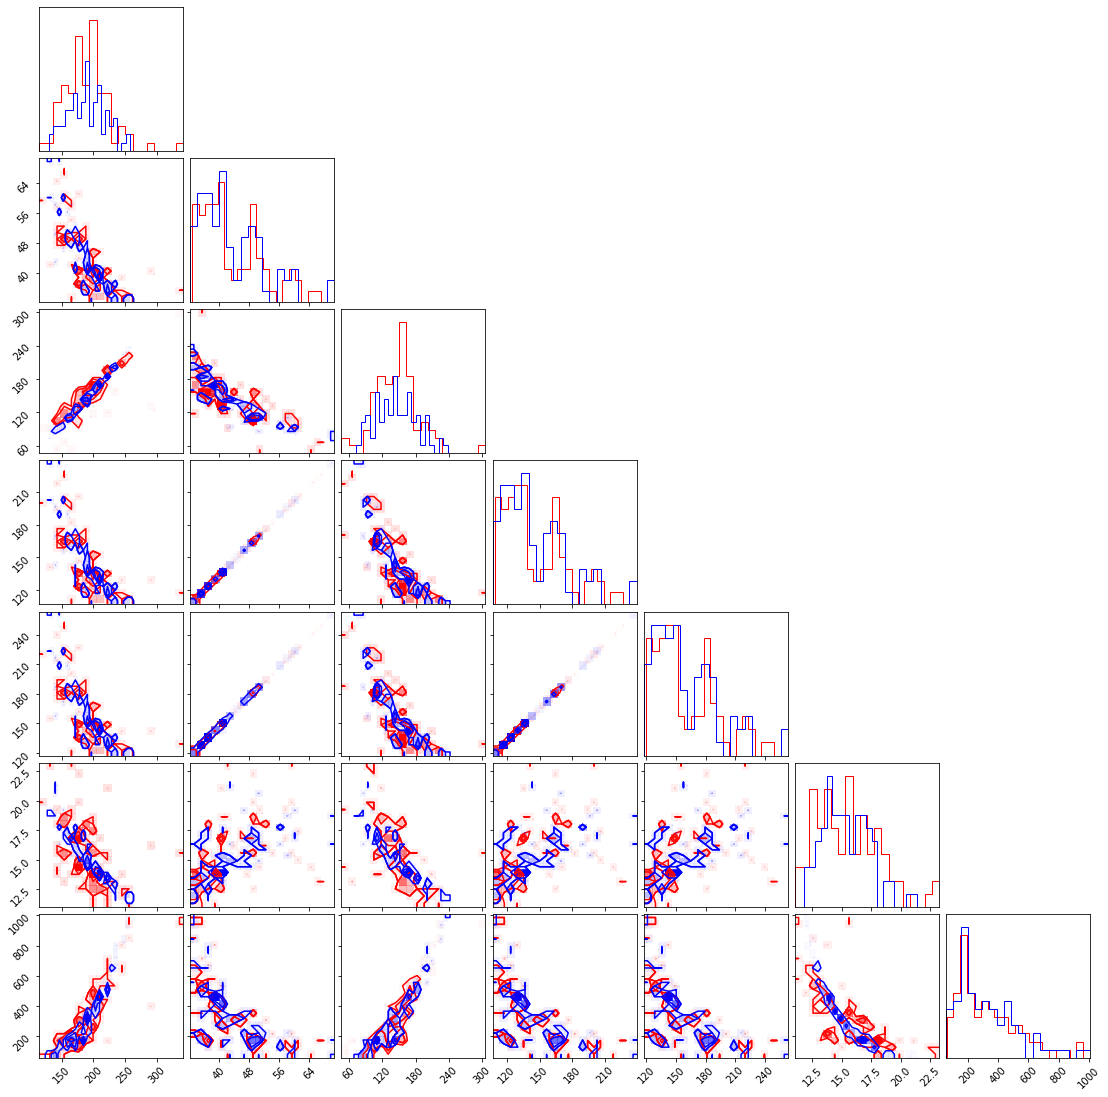

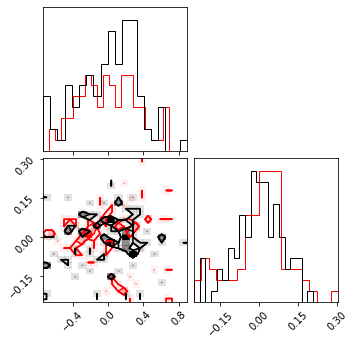

In [83]:
def old(l):
        ''' From Kalinger 2014'''
        numax, delta_a1, delta_a2, delta_width, delta_height = l 
        p = [delta_a1 * 3382 * numax**-0.609, 
             0.317 * numax**0.970, 
             delta_a2 * 3382 * numax**-0.609, 
             0.948 * numax**0.992,
             numax, 
             delta_width * 0.3 * numax **0.8, 
             delta_height * 3335 * numax**-0.564]
        return p

ln = pd.read_csv('learnt.csv')
ln.head()
ln = ln[ln.Numax > 100]
ln = ln[ln.d3 > 0.2]
ln = ln[ln.d3 < 2.0]
lnn = ln.drop(columns=['KIC', 'White']).to_numpy()
full = np.array([old(n) for n in lnn])

ex = expand()
ex.learn(full, n_components=2)
ex.get_latent_summary(full)
ex.plot_compare(full)
ex.plot_latent(full)

In [94]:
class dtwoterm():
    ''' At some point should JAX '''
    def __init__(self, pg, pca):
        self.pg = pg
        self.f = self.pg.frequency.value
        self.O = self.pg.power.value
        self.O = self.O[len(self.f) % 4:]
        self.f = self.f[len(self.f) % 4:]
        self.f_dash = np.arange(self.f[0], self.f[-1] * 2, self.f[1] - self.f[0])
        self.pca = pca
        
    def harvey(self, a, b, c=4):
        return a**2 / b / (1 + (self.f_dash / b)**c)
    
    def eta(self):
        ''' TODO calculate just once ?!?'''
        x = jnp.pi * self.f_dash / 2 / self.f.max()
        return np.sin(x) / x
    
    def hump(self, numax, width, height):
        return height * jnp.exp(-0.5 * (self.f_dash - numax)**2 / width**2)
    
    def model(self, p): 
        a1, b1, a2, b2, numax, width, height, white = p
        mod = (self.harvey(a1, b1) + self.harvey(a2, b2) + self.hump(numax, width, height)) * self.eta()**2 + white
        return jnp.abs(mod[:len(self.f)] + mod[-1:len(mod) - len(self.f) - 1:-1])
    
    def full_model(self, l):
        return self.model(self.expand(l))
    
    #@partial(jit, static_argnums=0)
    def loglike(self, l): 
        M = self.full_model(l)
        return -0.5 * jnp.sum(jnp.log(M) + self.O/M)
    
    def expand(self, l):
        p = self.pca(l[:2])
        return [l[2] * p[0], 
                 p[1], 
                 l[3] * p[2], 
                 p[3],
                 p[4], 
                 l[4] * p[5], 
                 l[5] * p[6], 
                 l[6]]
    
    def ptform(self, u): 
        return [scipy.stats.norm.ppf(u[0]) * 
                    self.pca.summary[1][0]  + self.pca.summary[0][0], 
                scipy.stats.norm.ppf(u[1]) * 
                    self.pca.summary[1][1]  + self.pca.summary[0][1], 
                10**(scipy.stats.norm.ppf(u[2]) * 0.01),
                10**(scipy.stats.norm.ppf(u[3]) * 0.01),
                10**(scipy.stats.norm.ppf(u[4]) * 0.01),
                10**(scipy.stats.norm.ppf(u[5]) * 0.01),
                u[6] * np.median(self.O[-100:-1])]
    
    def __call__(self): 
        self.sampler = dynesty.NestedSampler(self.loglike, self.ptform, 7,
                               nlive=100, sample='rwalk')
        self.sampler.run_nested()
        res = self.sampler.results
        
        samples, weights = res.samples, np.exp(res.logwt - res.logz[-1])
        new_samples = dynesty.utils.resample_equal(samples, weights)
        return new_samples
        

class tutor():
    def __init__(self, df, expand, plot=True):
        ''' 
        df: DataFrame 
            Contains the list of the targets with some information that might be useful
        
        '''
        self.df = df
        self.plot = plot
        self.output_file = 'learnt_new.csv'
        self.labels = ['KIC', 'Numax', 'White', 'd1', 'd2', 'd3', 'Height']
        try:
            self.output_df = pd.read_csv(self.output_file)
        except:
            self.output_df = pd.DataFrame(columns=self.labels)
        self.expand = expand
        
    def pick_one(self): 
        return self.df.sample()
    
    def start(self):
        self.target = self.pick_one()
        print(self.target)
        
    def get_target_data(self):
        self.lc = lk.search_lightcurve('KIC ' + str(self.target.KIC.values[0]), author="Kepler", 
                                  quarter=[6,7,8,9,10], cadence="long").download_all().stitch()
        self.lc = self.lc.normalize()
        self.lc.flux *= 1e6
        self.pg = self.lc.to_periodogram(oversample_factor=1, normalization='PSD')
        if self.plot:
            self.plot_guess()
            
    def plot_guess(self):
        self.fit = dtwoterm(self.pg, self.expand)
        ax = self.pg.plot('log')
        ax.plot(self.pg.frequency, self.pg.smooth(filter_width=2.0).power)
        ax.plot(self.fit.f, self.fit.full_model([0, 0, 1., 1., 1., 1., 
                                                 np.median(self.fit.O[-100:-1]) / 2]))
        ax.set_xlim([10, 288])
            
    def fit_target_data(self):
        self.fit = dtwoterm(self.pg, self.expand)
        self.samples = self.fit()
        if self.plot:
            corner.corner(self.samples)
            self.posterior_pred_plot()
            
    def posterior_pred_plot(self):
        ax = self.pg.plot('log')
        ax.plot(self.pg.frequency, self.pg.smooth(filter_width=2.0).power)
        ax.plot(self.pg.frequency, self.pg.smooth(filter_width=20.0).power)
        for i in range(100):
            ax.plot(self.fit.f, self.fit.full_model(self.samples[i, :]), c='r', alpha=0.05)
        ax.set_xlim(10, 288)
        
    def save_summary_stats(self, output): 
        print(output)
        nd = [[i, *output[i]] for i in output]
        tmp = pd.DataFrame(columns=self.labels, data=nd)
        tmp.to_csv(self.output_file, index=False)
        
        
    def run_n(self, n):
        output = {}
        for i in range(n):
            self.start()
            self.get_target_data()
            self.fit_target_data()
            output[self.target.KIC.values[0]] = np.mean(self.samples, axis=0)
        self.save_summary_stats(output)
        

          KIC     Dnu     Nmax    Teff
2612  7022581  14.319  195.814  4948.8


1733it [01:41, 17.10it/s, +100 | bound: 89 | nc: 1 | ncall: 40116 | eff(%):  4.581 | loglstar:   -inf < -32724.066 <    inf | logz: -32739.103 +/-  0.157 | dlogz:  0.001 >  0.109]


{7022581: array([ 0.36130989,  0.05692064,  1.01894404,  1.03397269,  1.00227581,
        0.99043563, 15.21121372])}


ValueError: 7 columns passed, passed data had 8 columns

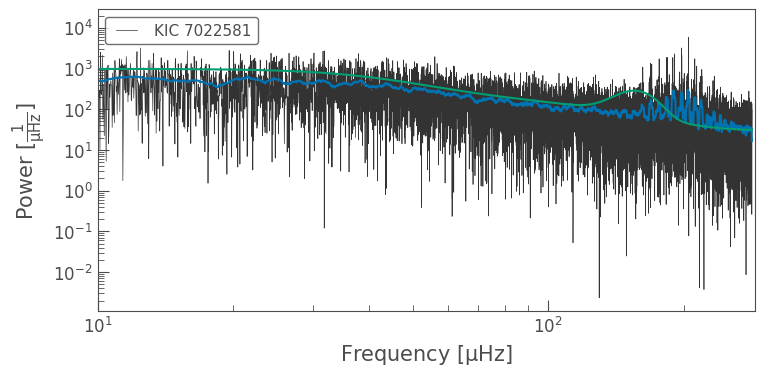

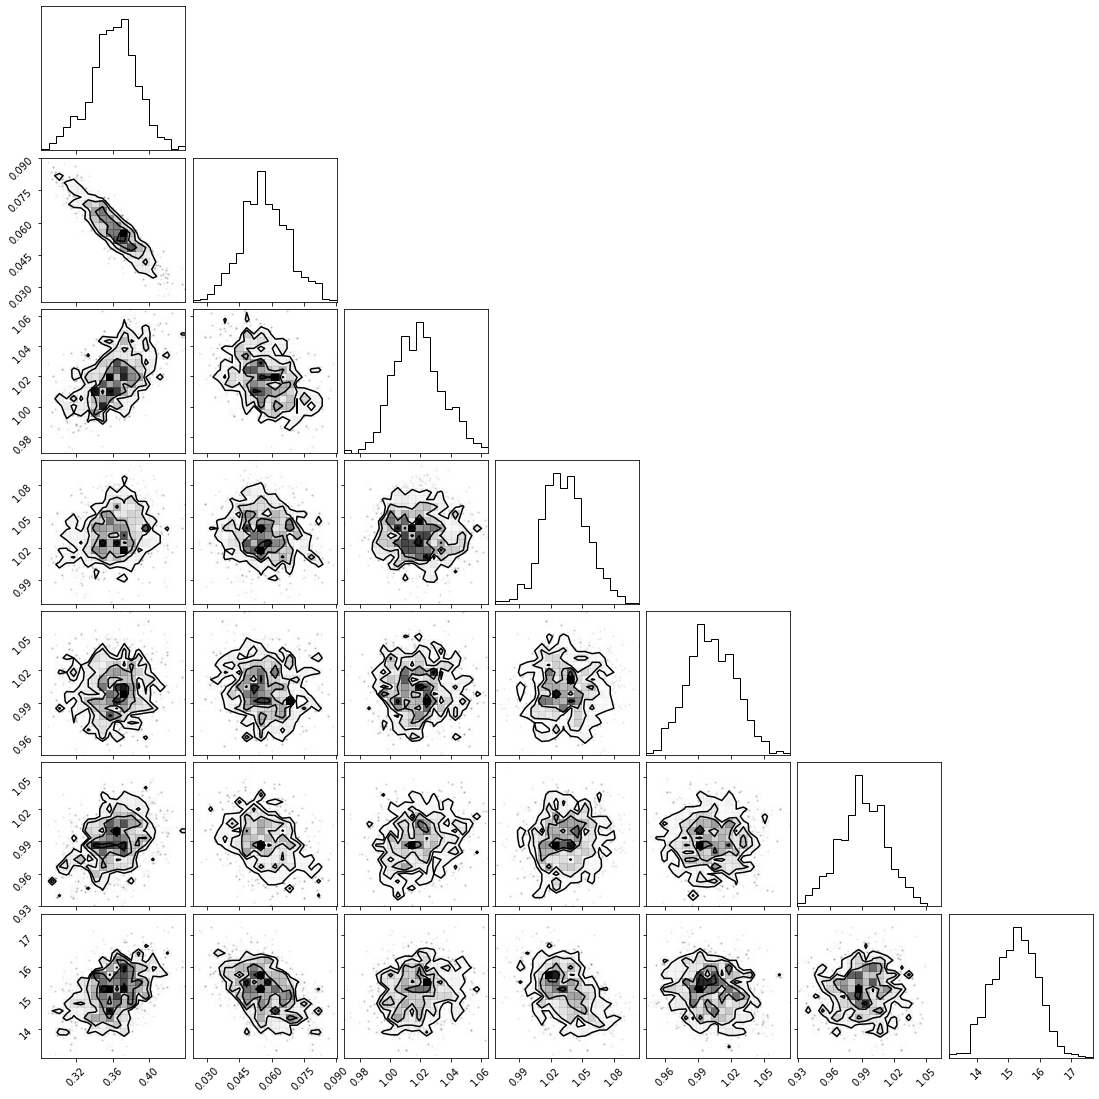

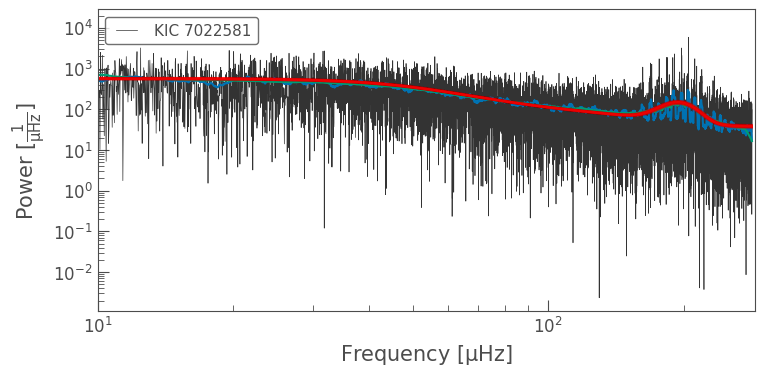

In [95]:
apo = tutor(df, ex)
apo.run_n(1)